##### Copyright 2020 The TensorFlow Authors.

In [ ]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Optimizing the Text Generation Model

<a href="https://colab.research.google.com/github/DTSense/Webinar_DeepLearning_4/blob/master/1_kobar_latihan/DTSense_NLP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Import TensorFlow and related functions

In [ ]:
import tensorflow as tf

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Other imports for processing data
import string
import numpy as np
import pandas as pd

## Get the Dataset

As noted above, we'll utilize the [Song Lyrics dataset](https://www.kaggle.com/mousehead/songlyrics) on Kaggle again.

In [ ]:
!wget --no-check-certificate \
    https://drive.google.com/uc?id=1LiJFZd41ofrWoBtW-pMYsfz1w8Ny0Bj8 \
    -O /tmp/songdata.csv

--2020-12-12 19:02:17--  https://drive.google.com/uc?id=1LiJFZd41ofrWoBtW-pMYsfz1w8Ny0Bj8
Resolving drive.google.com (drive.google.com)... 74.125.135.100, 74.125.135.139, 74.125.135.101, ...
Connecting to drive.google.com (drive.google.com)|74.125.135.100|:443... connected.
HTTP request sent, awaiting response... 302 Moved Temporarily
Location: https://doc-04-ak-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/mf1jme16nrodqg2dir5i94hhpkc1vht4/1607799675000/11118900490791463723/*/1LiJFZd41ofrWoBtW-pMYsfz1w8Ny0Bj8 [following]
--2020-12-12 19:02:19--  https://doc-04-ak-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/mf1jme16nrodqg2dir5i94hhpkc1vht4/1607799675000/11118900490791463723/*/1LiJFZd41ofrWoBtW-pMYsfz1w8Ny0Bj8
Resolving doc-04-ak-docs.googleusercontent.com (doc-04-ak-docs.googleusercontent.com)... 74.125.28.132, 2607:f8b0:400e:c04::84
Connecting to doc-04-ak-docs.googleusercontent.com (doc-04-ak-docs.googleusercontent.com)|74.125.

In [ ]:
# Read the dataset from csv - this time with 250 songs
dataset = pd.read_csv('/tmp/songdata.csv', dtype=str)[:10]

dataset

,artist,song,link,text
0,ABBA,Ahe's My Kind Of Girl,/a/abba/ahes+my+kind+of+girl_20598417.html,"Look at her face, it's a wonderful face \nAnd..."
1,ABBA,"Andante, Andante",/a/abba/andante+andante_20002708.html,"Take it easy with me, please \nTouch me gentl..."
2,ABBA,As Good As New,/a/abba/as+good+as+new_20003033.html,I'll never know why I had to go \nWhy I had t...
3,ABBA,Bang,/a/abba/bang_20598415.html,Making somebody happy is a question of give an...
4,ABBA,Bang-A-Boomerang,/a/abba/bang+a+boomerang_20002668.html,Making somebody happy is a question of give an...
5,ABBA,Burning My Bridges,/a/abba/burning+my+bridges_20003011.html,"Well, you hoot and you holler and you make me ..."
6,ABBA,Cassandra,/a/abba/cassandra_20002811.html,Down in the street they're all singing and sho...
7,ABBA,Chiquitita,/a/abba/chiquitita_20002978.html,"Chiquitita, tell me what's wrong \nYou're enc..."
8,ABBA,Crazy World,/a/abba/crazy+world_20003013.html,I was out with the morning sun \nCouldn't sle...
9,ABBA,Crying Over You,/a/abba/crying+over+you_20177611.html,I'm waitin' for you baby \nI'm sitting all al...


### Preprocessing

In [ ]:
def tokenize_corpus(corpus, num_words=-1):
  # Fit a Tokenizer on the corpus
  if num_words > -1:
    tokenizer = Tokenizer(num_words=num_words)
  else:
    tokenizer = Tokenizer()
  tokenizer.fit_on_texts(corpus)
  return tokenizer

def create_lyrics_corpus(dataset, field):
  # Remove all other punctuation
  dataset[field] = dataset[field].str.replace('[{}]'.format(string.punctuation), '')
  # Make it lowercase
  dataset[field] = dataset[field].str.lower()
  # Make it one long string to split by line
  lyrics = dataset[field].str.cat()
  corpus = lyrics.split('\n')
  # Remove any trailing whitespace
  for l in range(len(corpus)):
    corpus[l] = corpus[l].rstrip()
  # Remove any empty lines
  corpus = [l for l in corpus if l != '']

  return corpus

In [ ]:
# Create the corpus using the 'text' column containing lyrics
corpus = create_lyrics_corpus(dataset, 'text')
# Tokenize the corpus
tokenizer = tokenize_corpus(corpus, num_words=2000)
total_words = tokenizer.num_words

# There should be a lot more words now
print(total_words)

2000


### Create Sequences and Labels

After preprocessing, we next need to create sequences and labels. Creating the sequences themselves is similar to before with `texts_to_sequences`, but also including the use of [N-Grams](https://towardsdatascience.com/introduction-to-language-models-n-gram-e323081503d9); creating the labels will now utilize those sequences as well as utilize one-hot encoding over all potential output words.

In [ ]:
sequences = []
for line in corpus:
	token_list = tokenizer.texts_to_sequences([line])[0]
	for i in range(1, len(token_list)):
		n_gram_sequence = token_list[:i+1]
		sequences.append(n_gram_sequence)

# Pad sequences for equal input length 
max_sequence_len = max([len(seq) for seq in sequences])
sequences = np.array(pad_sequences(sequences, maxlen=max_sequence_len, padding='pre'))

# Split sequences between the "input" sequence and "output" predicted word
input_sequences, labels = sequences[:,:-1], sequences[:,-1]
# One-hot encode the labels
one_hot_labels = tf.keras.utils.to_categorical(labels, num_classes=total_words)

In [ ]:
# Check out how some of our data is being stored
# The Tokenizer has just a single index per word
print(tokenizer.word_index['know'])
print(tokenizer.word_index['feeling'])
# Input sequences will have multiple indexes
print(input_sequences[5])
print(input_sequences[6])
# And the one hot labels will be as long as the full spread of tokenized words
print(one_hot_labels[5])
print(one_hot_labels[6])

### Train a Text Generation Model

Building an RNN to train our text generation model will be very similar to the sentiment models you've built previously. The only real change necessary is to make sure to use Categorical instead of Binary Cross Entropy as the loss function - we could use Binary before since the sentiment was only 0 or 1, but now there are hundreds of categories.

From there, we should also consider using *more* epochs than before, as text generation can take a little longer to converge than sentiment analysis, *and* we aren't working with all that much data yet. I'll set it at 200 epochs here since we're only use part of the dataset, and training will tail off quite a bit over that many epochs.

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Bidirectional

model = Sequential()
model.add(Embedding(total_words, 64, input_length=max_sequence_len-1))
model.add(Bidirectional(LSTM(20)))
model.add(Dense(total_words, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
history = model.fit(input_sequences, one_hot_labels, epochs=100, verbose=1)

Epoch 1/100
62/62 [==============================] - 0s 8ms/step - loss: 7.1253 - accuracy: 0.0202
Epoch 2/100
62/62 [==============================] - 1s 8ms/step - loss: 5.5985 - accuracy: 0.0399
Epoch 3/100
62/62 [==============================] - 1s 9ms/step - loss: 5.4464 - accuracy: 0.0338
Epoch 4/100
62/62 [==============================] - 1s 8ms/step - loss: 5.4010 - accuracy: 0.0399
Epoch 5/100
62/62 [==============================] - 1s 9ms/step - loss: 5.3515 - accuracy: 0.0333
Epoch 6/100
62/62 [==============================] - 1s 9ms/step - loss: 5.2881 - accuracy: 0.0383
Epoch 7/100
62/62 [==============================] - 1s 9ms/step - loss: 5.2309 - accuracy: 0.0388
Epoch 8/100
62/62 [==============================] - 1s 8ms/step - loss: 5.1802 - accuracy: 0.0404
Epoch 9/100
62/62 [==============================] - 1s 9ms/step - loss: 5.1377 - accuracy: 0.0394
Epoch 10/100
62/62 [==============================] - 0s 8ms/step - loss: 5.1048 - accuracy: 0.0459
Epoch 11/

### View the Training Graph

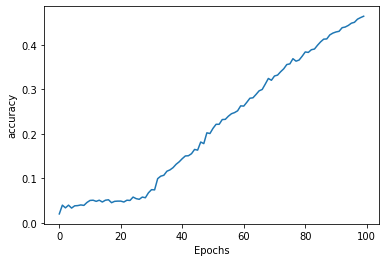

In [ ]:
import matplotlib.pyplot as plt

def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.show()

plot_graphs(history, 'accuracy')

### Generate new lyrics!

It's finally time to generate some new lyrics from the trained model, and see what we get. To do so, we'll provide some "seed text", or an input sequence for the model to start with. We'll also decide just how long of an output sequence we want - this could essentially be infinite, as the input plus the previous output will be continuously fed in for a new output word (at least up to our max sequence length).

In [ ]:
seed_text = "im feeling chills"
next_words = 100
  
for _ in range(next_words):
	token_list = tokenizer.texts_to_sequences([seed_text])[0]
	token_list = pad_sequences([token_list], maxlen=max_sequence_len-1, padding='pre')
	predicted = np.argmax(model.predict(token_list), axis=-1)
	output_word = ""
	for word, index in tokenizer.word_index.items():
		if index == predicted:
			output_word = word
			break
	seed_text += " " + output_word
print(seed_text)

im feeling chills me sing and i am your boomaboomerang and on my eyes never leave me feel fine end leave me feel fine end quiet quiet quiet end but like i eyes believe i eyes believe you leave me girl girl without you feel so on give and take of us know quiet quiet quiet quiet quiet quiet quiet quiet quiet world quiet quiet quiet quiet world eyes andante blue eyes dont am believe return to sender girl girl without good as new what a crazy world so quiet end but tender every eyes believe andante andante andante andante andante andante andante


## 250 Songs

Now we've seen a model trained on just a small sample of songs, and how this often leads to repetition as you get further along in trying to generate new text. Let's switch to using the 250 songs instead, and see if our output improves. This will actually be nearly 10K lines of lyrics, which should be sufficient.

Note that we won't use the full dataset here as it will take up quite a bit of RAM and processing time, but you're welcome to try doing so on your own later. If interested, you'll likely want to use only some of the more common words for the Tokenizer, which will help shrink processing time and memory needed (or else you'd have an output array hundreds of thousands of words long).

In [ ]:
# Read the dataset from csv - this time with 250 songs
dataset = pd.read_csv('/tmp/songdata.csv', dtype=str)[:250]

dataset

,artist,song,link,text
0,ABBA,Ahe's My Kind Of Girl,/a/abba/ahes+my+kind+of+girl_20598417.html,"Look at her face, it's a wonderful face \nAnd..."
1,ABBA,"Andante, Andante",/a/abba/andante+andante_20002708.html,"Take it easy with me, please \nTouch me gentl..."
2,ABBA,As Good As New,/a/abba/as+good+as+new_20003033.html,I'll never know why I had to go \nWhy I had t...
3,ABBA,Bang,/a/abba/bang_20598415.html,Making somebody happy is a question of give an...
4,ABBA,Bang-A-Boomerang,/a/abba/bang+a+boomerang_20002668.html,Making somebody happy is a question of give an...
...,...,...,...,...
245,Air Supply,Believer,/a/air+supply/believer_20522284.html,Believer \nI got no where to go \nBeliever ...
246,Air Supply,Big Cat,/a/air+supply/big+cat_20522283.html,Big cat walking on the wild side \nBig cat ta...
247,Air Supply,Black And Blue,/a/air+supply/black+and+blue_20154341.html,"Blue, blue is the color of skies \nBlue is th..."
248,Air Supply,Body Glove,/a/air+supply/body+glove_20522282.html,"The more you win, the more you gain \nAn open..."


In [ ]:
# Create the corpus using the 'text' column containing lyrics
corpus = create_lyrics_corpus(dataset, 'text')
# Tokenize the corpus
tokenizer = tokenize_corpus(corpus, num_words=2000)
total_words = tokenizer.num_words

# There should be a lot more words now
print(total_words)

2000


In [ ]:
sequences = []
for line in corpus:
	token_list = tokenizer.texts_to_sequences([line])[0]
	for i in range(1, len(token_list)):
		n_gram_sequence = token_list[:i+1]
		sequences.append(n_gram_sequence)

# Pad sequences for equal input length 
max_sequence_len = max([len(seq) for seq in sequences])
sequences = np.array(pad_sequences(sequences, maxlen=max_sequence_len, padding='pre'))

# Split sequences between the "input" sequence and "output" predicted word
input_sequences, labels = sequences[:,:-1], sequences[:,-1]
# One-hot encode the labels
one_hot_labels = tf.keras.utils.to_categorical(labels, num_classes=total_words)

### Train a (Better) Text Generation Model

With more data, we'll cut off after 100 epochs to avoid keeping you here all day. You'll also want to change your runtime type to GPU if you haven't already (you'll need to re-run the above cells if you change runtimes).

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Bidirectional

model = Sequential()
model.add(Embedding(total_words, 64, input_length=max_sequence_len-1))
model.add(Bidirectional(LSTM(20)))
model.add(Dense(total_words, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
history = model.fit(input_sequences, one_hot_labels, epochs=100, verbose=1)

Epoch 1/100
1480/1480 [==============================] - 12s 8ms/step - loss: 5.9800 - accuracy: 0.0463
Epoch 2/100
1480/1480 [==============================] - 12s 8ms/step - loss: 5.6578 - accuracy: 0.0520
Epoch 3/100
1480/1480 [==============================] - 12s 8ms/step - loss: 5.4555 - accuracy: 0.0709
Epoch 4/100
1480/1480 [==============================] - 12s 8ms/step - loss: 5.2779 - accuracy: 0.1001
Epoch 5/100
1480/1480 [==============================] - 12s 8ms/step - loss: 5.1254 - accuracy: 0.1204
Epoch 6/100
1480/1480 [==============================] - 12s 8ms/step - loss: 5.0091 - accuracy: 0.1283
Epoch 7/100
1480/1480 [==============================] - 12s 8ms/step - loss: 4.8999 - accuracy: 0.1394
Epoch 8/100
1480/1480 [==============================] - 12s 8ms/step - loss: 4.7826 - accuracy: 0.1502
Epoch 9/100
1480/1480 [==============================] - 12s 8ms/step - loss: 4.6549 - accuracy: 0.1625
Epoch 10/100
1480/1480 [==============================] - 12s 8m

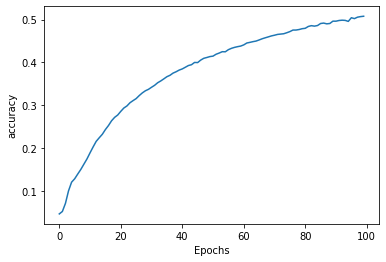

In [ ]:
import matplotlib.pyplot as plt

def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.show()

plot_graphs(history, 'accuracy')

### Generate better lyrics!

This time around, we should be able to get a more interesting output with less repetition.

In [ ]:
seed_text = "im feeling chills"
next_words = 100
  
for _ in range(next_words):
	token_list = tokenizer.texts_to_sequences([seed_text])[0]
	token_list = pad_sequences([token_list], maxlen=max_sequence_len-1, padding='pre')
	predicted = np.argmax(model.predict(token_list), axis=-1)
	output_word = ""
	for word, index in tokenizer.word_index.items():
		if index == predicted:
			output_word = word
			break
	seed_text += " " + output_word
print(seed_text)

im feeling chills me to the bone that you think me start you feel the pain i miss lovin you and joe round and seas questions tonight might sounds knew beast believed reaching games first talked temperature cloud beast ball point rights cloud light of female company likes rushing paint knew the devil are your brother reaching dice honey i did you humdehumhum never never never be me for a little good with a minute honolulu this block beyond learn lucky i do is flowing over over bags your female dreamworld likes rushing open grown travel row starts memries x4 noises noises glowing


### Varying the Possible Outputs

In running the above, you may notice that the same seed text will generate similar outputs. This is because the code is currently always choosing the top predicted class as the next word. What if you wanted more variance in the output? 

Switching from `model.predict_classes` to `model.predict_proba` will get us all of the class probabilities. We can combine this with `np.random.choice` to select a given predicted output based on a probability, thereby giving a bit more randomness to our outputs.

In [ ]:
# Test the method with just the first word after the seed text
seed_text = "im feeling chills"
next_words = 100
  
token_list = tokenizer.texts_to_sequences([seed_text])[0]
token_list = pad_sequences([token_list], maxlen=max_sequence_len-1, padding='pre')
predicted_probs = model.predict(token_list)[0]
predicted = np.random.choice([x for x in range(len(predicted_probs))], 
                             p=predicted_probs)
# Running this cell multiple times should get you some variance in output
print(predicted)

381


In [ ]:
# Use this process for the full output generation
seed_text = "im feeling chills"
next_words = 100
  
for _ in range(next_words):
  token_list = tokenizer.texts_to_sequences([seed_text])[0]
  token_list = pad_sequences([token_list], maxlen=max_sequence_len-1, padding='pre')
  predicted_probs = model.predict(token_list)[0]
  predicted = np.random.choice([x for x in range(len(predicted_probs))],
                               p=predicted_probs)
  output_word = ""
  for word, index in tokenizer.word_index.items():
    if index == predicted:
      output_word = word
      break
  seed_text += " " + output_word
print(seed_text)

im feeling chills until you humdehumhum showed he gently knew without to stay hawaii track hawaii bitch of the real last female company falling knew im going crazy in dark kin minds softly earth day smokin stinky heh x2 wants rushing knows wed school around my reaching beyond glory beats cow silly eats horns its done street im here is me make my trees sailing miss its breaking this ball man will see going through following following feeling next smiles if with reaching but we humdehumhum the breakfast humdehumhum in not sore eyes the office half her song gotta hoppin lights lights state


## Credits (Reference)

> - [Lex Fridman's MIT Deep Learning](https://github.com/lexfridman/mit-deep-learning)
> - [Intro to TensorFlow Udacity](https://classroom.udacity.com/courses/ud187/l)
> - [TensorFlow Examples Constructing Text Generation](https://github.com/tensorflow/examples/blob/master/courses/udacity_intro_to_tensorflow_for_deep_learning/l10c03_nlp_constructing_text_generation_model.ipynb)
> - [TensorFlow Examples Optimizing Text Generation](https://github.com/tensorflow/examples/blob/master/courses/udacity_intro_to_tensorflow_for_deep_learning/l10c04_nlp_optimizing_the_text_generation_model.ipynb)
> - [TensorFlow Tutorial](https://www.tensorflow.org/tutorials)
